In [1]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.ImgUtils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, EvalTracker, presetCubeViews, bytesToPic,
         croppedPic, bytesToPic2, colorInRange)

from skimage.filters import sobel, gaussian, scharr, threshold_adaptive

from modules.IterThresh import iterThreshA
from modules.AnalysisHelpers import imgToColors, pointsToList

from modules.AnalysisHelpers import (applyTracker, roiSelectZoomWindow,
                                     roiSelectScoreWindow)

In [2]:
DATA_DIR = "../data/misc/books/iterthresha-vizdebug-1/"

db_name = "interprocOrange.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSo = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

print [_gs.frameCounter for _gs in listGSo]

col1, col2 = [], []

for _gs in listGSo:
    _gs.initDisplay()
    col1.append(_gs.getOrigFrame())
    col2.append(_gs.display.scoreFrame.copy())
    
chart_data = [col1, col2]

[0, 9, 78, 116, 136, 176, 195, 246, 307, 340]


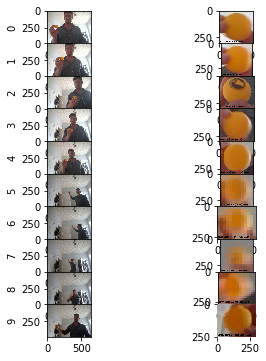

In [3]:
multiPlot(chart_data, hspace = 0, wspace = 0, figsize = (6,6), input_transform_titles = range(len(chart_data[0])),
         bGrid=True)

### Create two Trackers with separate Parameters

tracker2 works much better

In [27]:
tracker = TrackFactory(on=True)
tracker.setInit(ballColor = "orange")
tracker.setAlgoEnum(1)
tracker.threshInitial = [(6, 30, 90), (64, 255, 255)]
tracker.getTrackParams()

{'repair_iterations': 1,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (6, 30, 90),
 'threshes': [((6, 30, 120), (64, 255, 255)),
  ((64, 100, 110), (90, 255, 255)),
  ((90, 120, 130), (120, 255, 255))],
 'tracking_blur': 1}

In [28]:
tracker2 = TrackFactory(on=True)
tracker2.setInit(ballColor = "orange")
tracker2.setAlgoEnum(1)
tracker2.threshInitial = [(6, 30, 120), (64, 255, 255)]
tracker2.getTrackParams()

{'repair_iterations': 1,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (6, 30, 120),
 'threshes': [((6, 30, 120), (64, 255, 255)),
  ((64, 100, 110), (90, 255, 255)),
  ((90, 120, 130), (120, 255, 255))],
 'tracking_blur': 1}

In [33]:
def showSuccess( _listGS, _tracker, _displayImgs):
    ''' display a plot of each scoreWindow and Y or n for trackSuccess'''

    ev = EvalTracker()
    chart_legend = ["n", "Y"]
    
    outputData = applyTracker(_listGS, _tracker, bLogPlts=False)
    
    chart_col_title = []
    for _i, _gs in enumerate(_listGS):
        
        ev.setBaselineScore(_gs.displayInputScore)
        
#         chart_col_title.append( chart_legend[int(
#             ev.checkTrackSuccess(outputData['listScore'][_i])
#             )] 
#         )

        chart_col_title.append( str(round(
            ev.distanceFromBaseline(outputData['listScore'][_i])
            ,0)) 
        )
                          
    chart_data = [[elem] for elem in _displayImgs]

    multiPlot(chart_data
             ,input_frame_titles = chart_col_title
             ,bGrid = False
             ,bForceTitles = True
             )

### Print Distance of HandScore center vs. TrackScore center

under different tracker params; clearly tracker2 is quite accurate

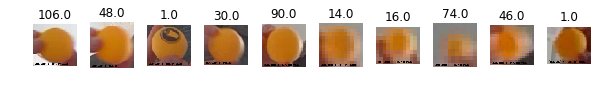

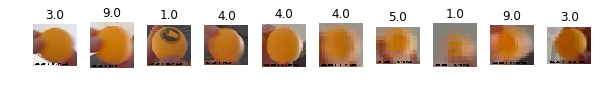

In [34]:
listImgs = [_gs.display.scoreFrame.copy() for _gs in listGSo]

showSuccess(listGSo, tracker, listImgs)

showSuccess(listGSo, tracker2, listImgs)

In [37]:
thresh2 = [
            tracker2.getTrackParams()['thresh_lo']
           ,tracker2.getTrackParams()['thresh_hi']
          ]
thresh2

[(6, 30, 120), (64, 255, 255)]

### PCM for orange ball set, clearly "view3" is the most informative for this color

In [42]:
views1 = presetCubeViews()
view1 = views1[0][1]
view2 = views1[1][1]
view3 = views1[2][1]
print view1, view2, view3

{'elevation': 95, 'azimuth': -81} {'elevation': -4, 'azimuth': -166} {'elevation': 145, 'azimuth': 81}


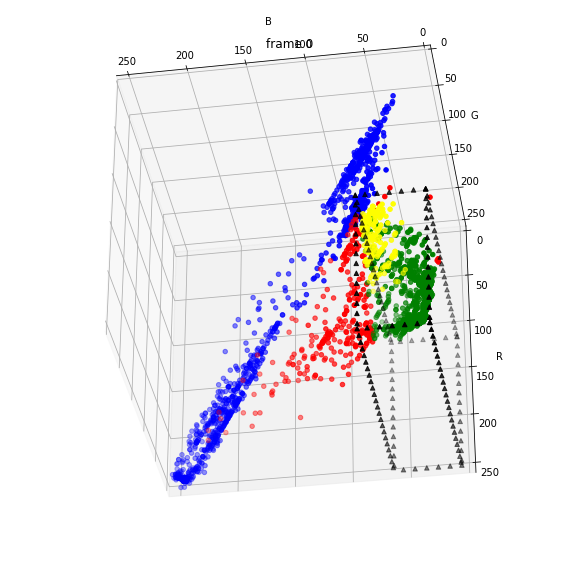

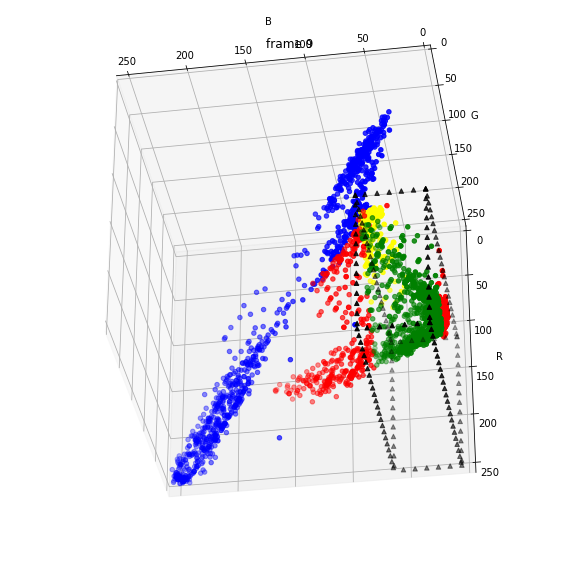

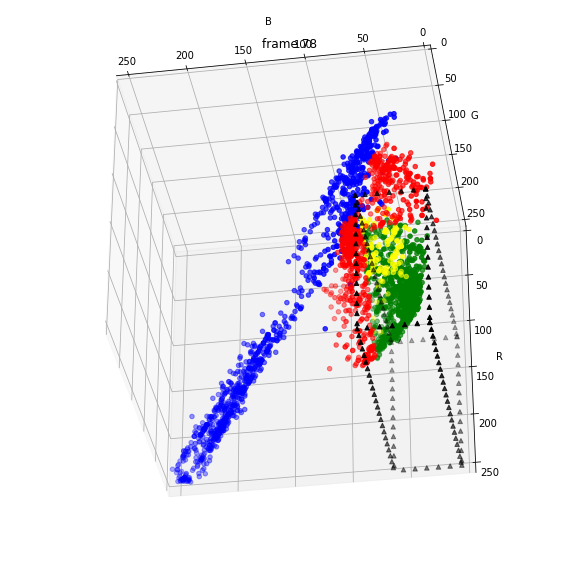

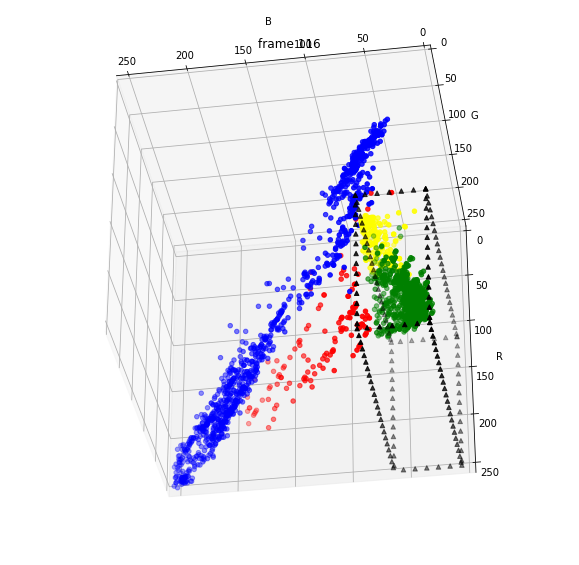

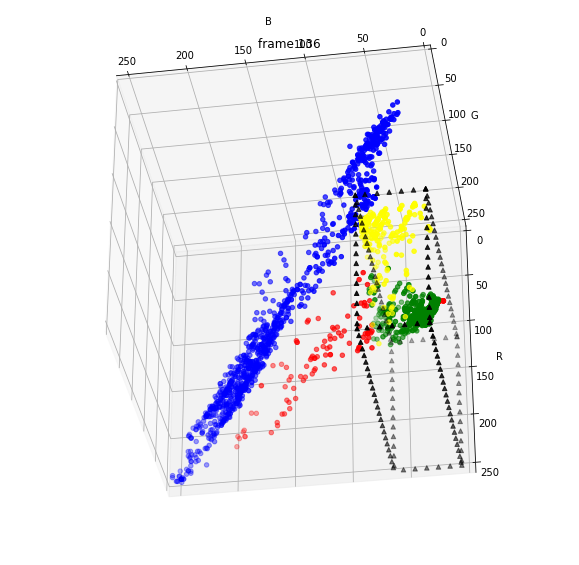

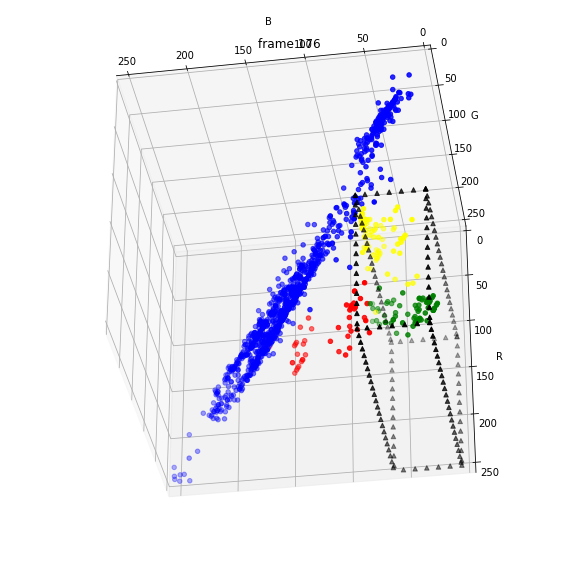

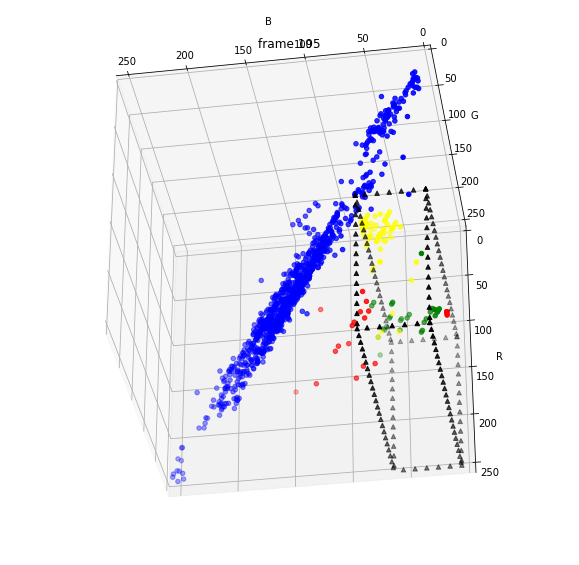

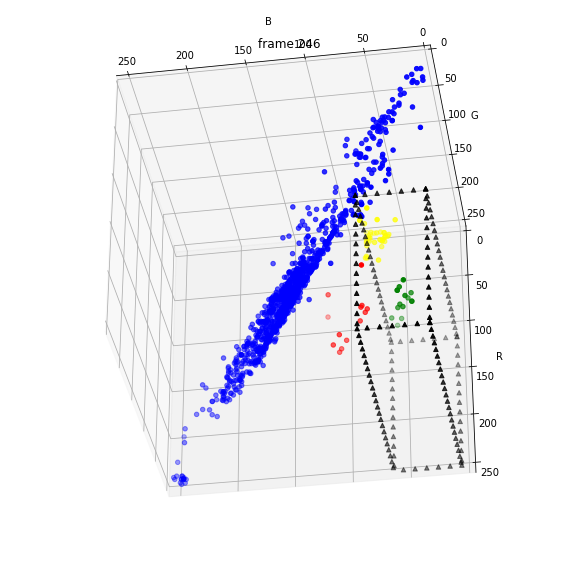

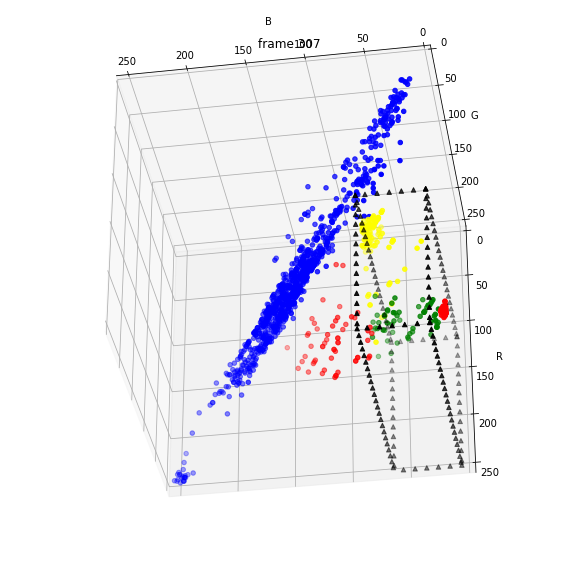

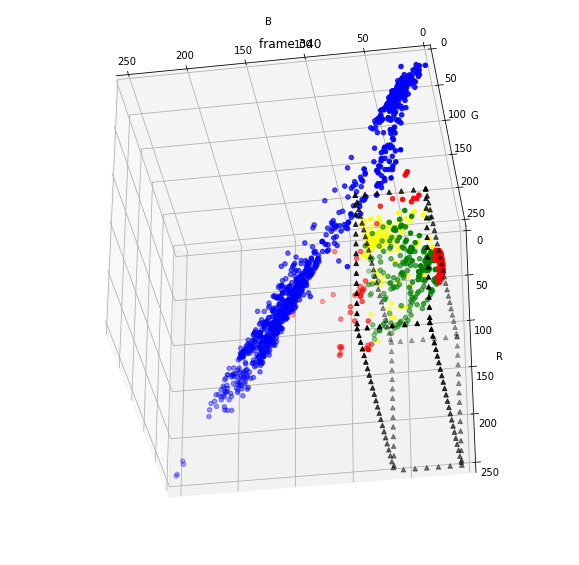

In [44]:
confusionPlotByImage(listGS = listGSo, inputThresh = thresh2, viewPositionDefined = view3, bOutputScore=False)

### Try corrected multi-thresh

In [45]:
tracker3 = TrackFactory(on=True)
tracker3.setInit(ballColor = "orange")
tracker3.setAlgoEnum(1)
tracker3.getTrackParams()

{'repair_iterations': 1,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (6, 30, 120),
 'threshes': [((6, 30, 120), (64, 255, 255)),
  ((64, 100, 110), (90, 255, 255)),
  ((90, 120, 130), (120, 255, 255))],
 'tracking_blur': 1}

In [46]:
tracker3.threshes = [
  ((6, 30, 120), (64, 255, 255)),
  ((64, 100, 180), (90, 255, 255)),
  ((90, 120, 200), (120, 255, 255))
]

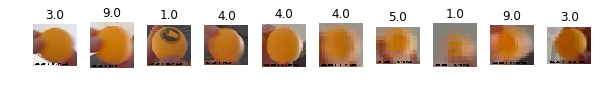

In [47]:
listImgs = [_gs.display.scoreFrame.copy() for _gs in listGSo]

showSuccess(listGSo, tracker3, listImgs)